<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Copy_of_research_project_final_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

# NewscatcherAPI key
newscatcher_api_key = 'VW9dbNuM7_mnY4Y3_pk2oTIaEmjw1_Th9av2zGaKP7c'

# Broader financial queries related to U.S. Treasury bonds
queries = [
    # U.S. Financial Queries
    'U.S. Treasury',
    'Treasury Bonds',
    'Bond Market',
    'Government Bonds',
    'U.S. Treasury Notes',
    'U.S. Treasury Bills',
    'Corporate Bonds',
    'Municipal Bonds',
    'Bond Yields',
    'Bond Interest Rates',
    'Fixed-Income Securities',
    'Federal Reserve Bonds',
    'Inflation-Linked Bonds',
    'Long-Term Bonds',
    'Short-Term Bonds',
    'Bond Auctions',
    'Treasury Bond Rates',
    'Treasury Securities',
    'Sovereign Debt',
    'Yield Curve',
    'Treasury Inflation-Protected Securities (TIPS)',
    'U.S. Debt Market',
    'Coupon Bonds',
    'Bond Maturity Dates',
    'U.S. Treasury Issuances',
    'Debt Instruments',
    'Bond Trading',
    'Secondary Bond Market',
    'U.S. National Debt',
    'Treasury Bond Investments',
    'Interest Rate Risk in Bonds',

    # UK Financial Queries
    'UK Treasury',
    'UK Government Bonds',
    'Gilt Bonds',
    'Corporate Bonds UK',
    'UK Bond Market',
    'UK Inflation-Linked Bonds',
    'UK Debt Instruments',
    'UK Sovereign Debt',
    'Bank of England Bonds',
    'UK Bond Yields',
    'UK Treasury Notes',
    'UK Treasury Bills',
    'UK National Debt',
    'UK Fixed-Income Securities',
    'UK Bond Auctions',
    'UK Yield Curve',
    'Long-Term UK Bonds',
    'Short-Term UK Bonds',
    'UK Bond Interest Rates',
    'UK Debt Market',

    # South Africa Financial Queries
    'South African Treasury',
    'South African Government Bonds',
    'Rand-Denominated Bonds',
    'Corporate Bonds South Africa',
    'South African Bond Market',
    'Inflation-Linked Bonds South Africa',
    'South African Sovereign Debt',
    'Reserve Bank of South Africa Bonds',
    'South African Bond Yields',
    'South African Debt Instruments',
    'South African Treasury Notes',
    'South African Treasury Bills',
    'South African National Debt',
    'South African Fixed-Income Securities',
    'South African Bond Auctions',
    'South African Yield Curve',
    'Long-Term South African Bonds',
    'Short-Term South African Bonds',
    'South African Bond Interest Rates',
    'South African Debt Market'
]


# Set up VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    # Check if text is None, and return 'Neutral' if it is
    if text is None:
        return 'Neutral'
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


# Function to get news articles from NewscatcherAPI
def get_news(query, api_key, start_date, end_date, num_articles=100):
    url = f'https://api.newscatcherapi.com/v2/search?q={query}&lang=en&from={start_date}&to={end_date}&page_size={num_articles}'
    headers = {
        'x-api-key': api_key
    }
    response = requests.get(url, headers=headers)
    data = response.json()

    if response.status_code != 200:
        print(f"Error fetching data for query '{query}': {data.get('message')}")
        return []

    news_data = []
    articles = data.get('articles', [])
    for article in articles:
        news_content = article.get('summary') if article.get('summary') else article.get('excerpt')
        sentiment = get_sentiment(news_content)
        news_data.append([article['clean_url'], query, sentiment, news_content])

    return news_data

# Define your date range
start_date = '2024-02-01'
end_date = '2025-02-01'

# Store all news data
all_news = []

for query in queries:
    all_news.extend(get_news(query, newscatcher_api_key, start_date, end_date))

# Check if any news was retrieved
if not all_news:
    print("No news articles were retrieved. Try broadening your queries or checking the API key.")
else:
    # Create a DataFrame
    df = pd.DataFrame(all_news, columns=['Source', 'Entity', 'Sentiment', 'News Content'])

    # Split the data into training and validation sets
    train, validation = train_test_split(df, test_size=0.2, random_state=42)

    # Save to CSV
    train.to_csv('financial_news_bonds_sentiment_train.csv', index=False)
    validation.to_csv('financial_news_bonds_sentiment_val.csv', index=False)

    # Print the first few rows of the training and validation sets
    print("Training Set:")
    print(train.head())

    print("\nValidation Set:")
    print(validation.head())


Training Set:
              Source                     Entity Sentiment  \
3248      menafn.com        UK Government Bonds  Positive   
181         wdam.com             Treasury Bonds  Positive   
3601  headtopics.com  UK Inflation-Linked Bonds  Positive   
794         kalb.com            Municipal Bonds  Positive   
3362       yahoo.com                 Gilt Bonds  Positive   

                                           News Content  
3248  (MENAFN- The Conversation)\nUK borrowing costs...  
181   The terms Treasury note, Treasury bond and Tre...  
3601  Amundi US TIPS Government Inflation-Linked Bon...  
794   While stocks get most of the attention in the ...  
3362  What are bonds?\nBonds, sometimes known as fix...  

Validation Set:
                Source                        Entity Sentiment  \
4977         yahoo.com        UK Bond Interest Rates  Negative   
3305          hl.co.uk                    Gilt Bonds  Positive   
4391  sputnikglobe.com              UK National Debt  Ne

In [4]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

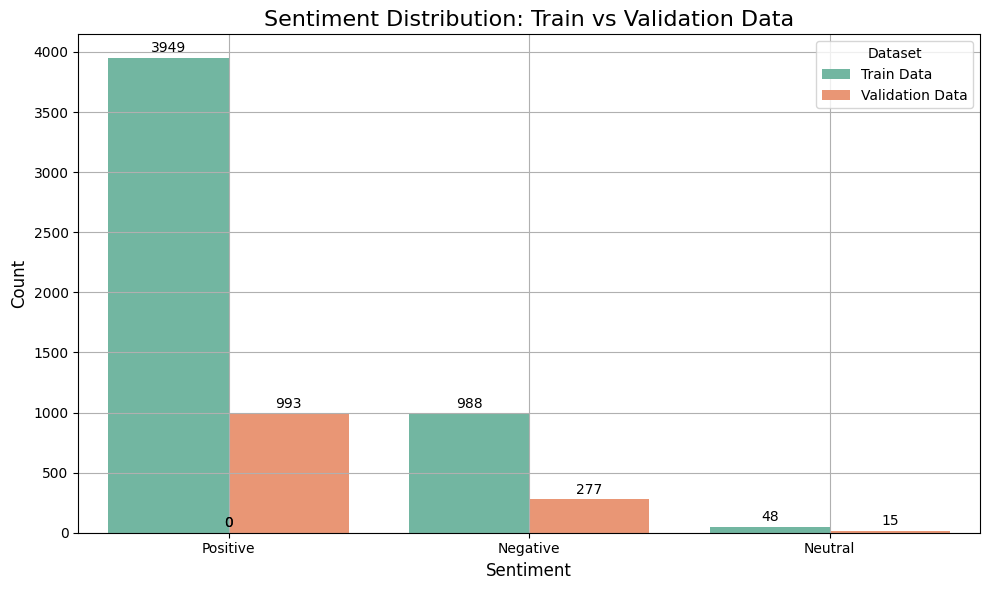

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
train_sentiment_counts = train['Sentiment'].value_counts().rename('Train Data')
validation_sentiment_counts = validation['Sentiment'].value_counts().rename('Validation Data')

# Combine counts into a DataFrame
combined_sentiment_counts = pd.DataFrame({
    'Train Data': train_sentiment_counts,
    'Validation Data': validation_sentiment_counts
})

# Fill missing values with 0
combined_sentiment_counts.fillna(0, inplace=True)

# Reset index to prepare for plotting
combined_sentiment_counts.reset_index(inplace=True)
combined_sentiment_counts.rename(columns={'index': 'Sentiment'}, inplace=True)

# Melt the DataFrame for easier plotting with seaborn
combined_sentiment_counts_melted = combined_sentiment_counts.melt(id_vars='Sentiment',
                                                                  var_name='Dataset',
                                                                  value_name='Count')

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Sentiment', y='Count', hue='Dataset', data=combined_sentiment_counts_melted, palette="Set2")

# Add count values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Add title and labels
plt.title('Sentiment Distribution: Train vs Validation Data', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


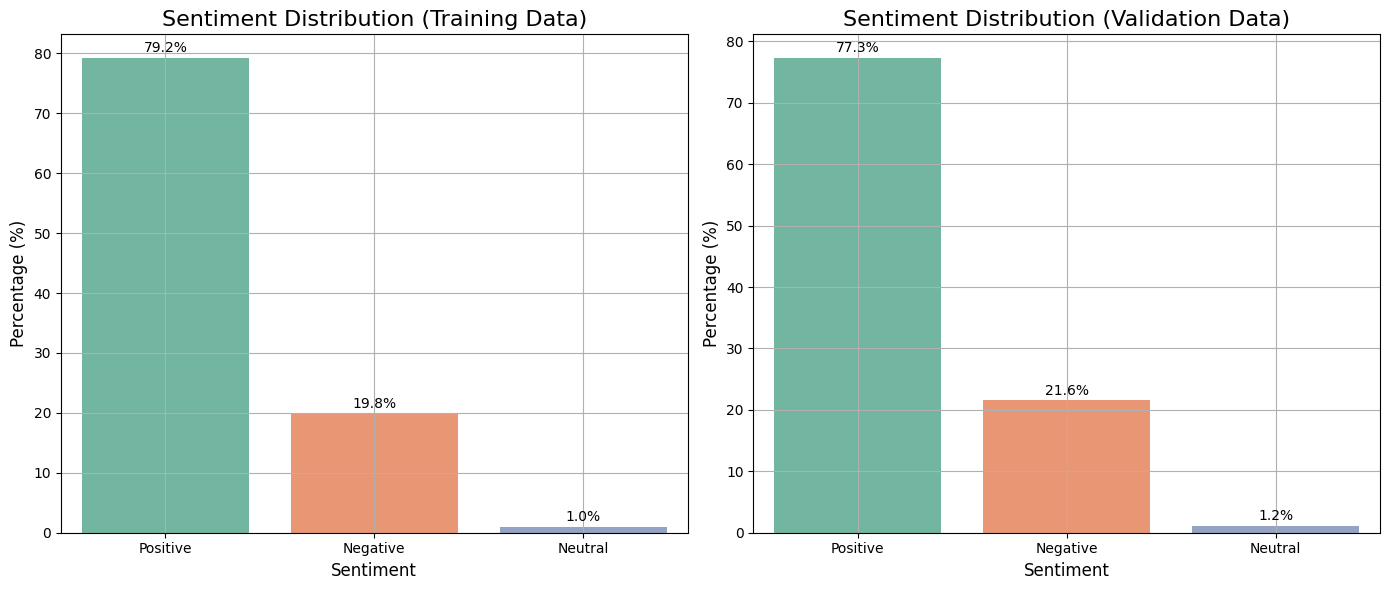

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment percentages for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts(normalize=True) * 100
sentiment_counts_validation = validation['Sentiment'].value_counts(normalize=True) * 100

# Create a figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjusting the figure size

# Plot training data sentiment distribution
barplot_train = sns.barplot(x=sentiment_counts_train.index, y=sentiment_counts_train.values, ax=ax1, palette="Set2")
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=16)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.grid(True)

# Add percentage labels on top of bars for training data
for p in barplot_train.patches:
    barplot_train.annotate(f'{p.get_height():.1f}%',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Plot validation data sentiment distribution
barplot_validation = sns.barplot(x=sentiment_counts_validation.index, y=sentiment_counts_validation.values, ax=ax2, palette="Set2")
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=16)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.grid(True)

# Add percentage labels on top of bars for validation data
for p in barplot_validation.patches:
    barplot_validation.annotate(f'{p.get_height():.1f}%',
                                (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [8]:
import plotly.graph_objects as go

# Assuming 'train' is your DataFrame with the necessary columns: 'News Content', 'Entity', 'Sentiment'

# Filter the DataFrame to include rows where 'News Content' has less than 40 words
# and is not None
filtered_data = train[(train['News Content'].notna()) & (train['News Content'].apply(lambda x: len(str(x).split()) < 40))]

# Sample 5 random rows from the filtered data
data_sample = filtered_data[['News Content', 'Entity', 'Sentiment']].sample(n=5, random_state=1)

# Define colors for sentiment categories
color_map = {
    'Positive': 'green',
    'Neutral': 'orange',
    'Negative': 'red'
}

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_sample.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_sample[k].tolist() for k in data_sample.columns],
        fill_color=[
            'lightcyan',  # News Content
            'lightcyan',  # Entity
            [color_map.get(s, 'gray') for s in data_sample['Sentiment']]  # Sentiment column
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Random 5 Rows of Training Data: News Content < 40 Words',
    width=1000,
    height=600,
)

fig.show()

In [9]:
import plotly.graph_objects as go

# Assuming 'validation' is your DataFrame with the necessary columns: 'News Content', 'Entity', 'Sentiment'

# Filter the DataFrame to include rows where 'News Content' has less than 40 words
filtered_validation = validation[validation['News Content'].apply(lambda x: len(x.split()) < 40)]

# Get the number of rows in the filtered DataFrame
num_rows = len(filtered_validation)

# Sample a maximum of 5 rows, or all rows if there are fewer than 5
sample_size = min(num_rows, 5)

# Sample random rows from the filtered validation data
data_test_sample = filtered_validation[['News Content', 'Entity', 'Sentiment']].sample(n=sample_size, random_state=1)

# Define colors for sentiment categories
color_map = {
    'Positive': 'green',
    'Neutral': 'orange',
    'Negative': 'red'
}

# Create a colorful table using Plotly for the sampled data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test_sample.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_test_sample[k].tolist() for k in data_test_sample.columns],  # Show the sampled rows
        fill_color=[
            'lightcyan',  # News Content
            'lightcyan',  # Entity
            [color_map.get(s, 'lightgray') for s in data_test_sample['Sentiment']]  # Sentiment
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Random 5 Rows of Validation Data: News Content < 40 Words',
    width=1000,
    height=600,
)

# Show the figure
fig.show()

# Optionally, save the figure as an HTML file
# fig.write_html("validation_data_sample.html")

Bert

In [10]:
%%time
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1})
    return df['News Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

# Define the custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'sentiment_model_BERT.pth')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.8763
Epoch 2/3, Test Accuracy: 0.8918
Epoch 3/3, Test Accuracy: 0.9152
CPU times: user 6min 17s, sys: 2min 15s, total: 8min 32s
Wall time: 9min 4s


In [11]:
!pip install scikit-learn
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.85      0.78      0.81       277
     Neutral       1.00      0.20      0.33        15
    Positive       0.93      0.96      0.95       993

    accuracy                           0.92      1285
   macro avg       0.93      0.65      0.70      1285
weighted avg       0.91      0.92      0.91      1285



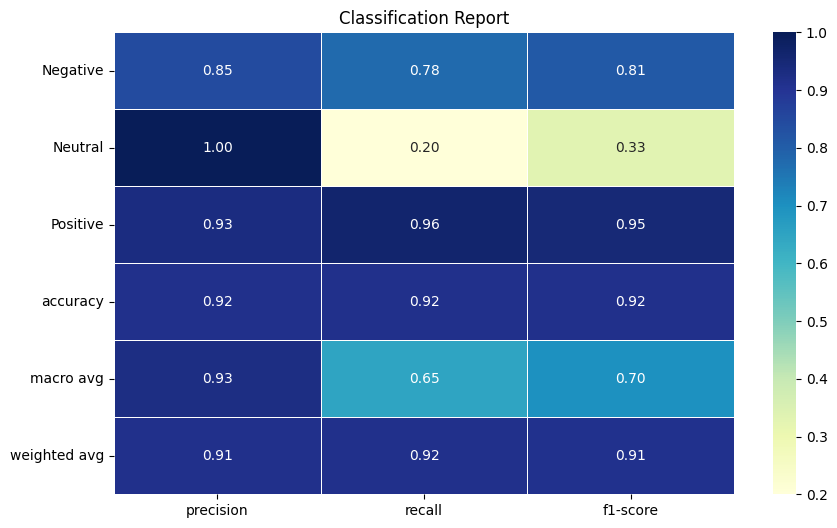

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the DataFrame using Seaborn's heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Classification Report')
plt.show()


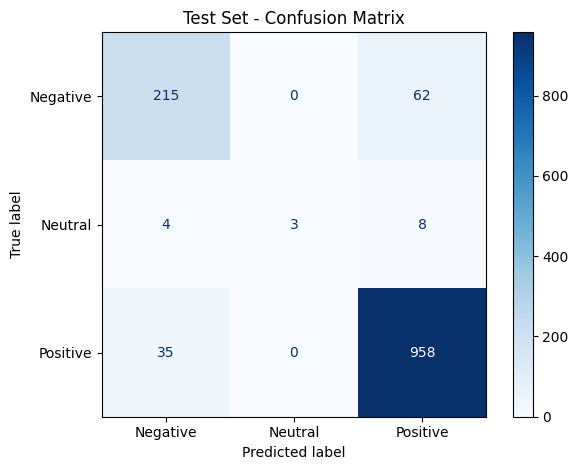

In [13]:
from sklearn.metrics import confusion_matrix
if not isinstance(test_true[0], str):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)
    labels = [0, 1, 2]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

RoBERTa

In [14]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1})
    return df['News Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

# Define the custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and datasets for RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Save the RoBERTa model
torch.save(model.state_dict(), 'sentiment_model_RoBERTa.pth')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.8389
Epoch 2/3, Test Accuracy: 0.8778
Epoch 3/3, Test Accuracy: 0.8942


In [15]:
!pip install scikit-learn
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.76      0.79      0.77       277
     Neutral       0.00      0.00      0.00        15
    Positive       0.93      0.94      0.94       993

    accuracy                           0.89      1285
   macro avg       0.56      0.58      0.57      1285
weighted avg       0.89      0.89      0.89      1285



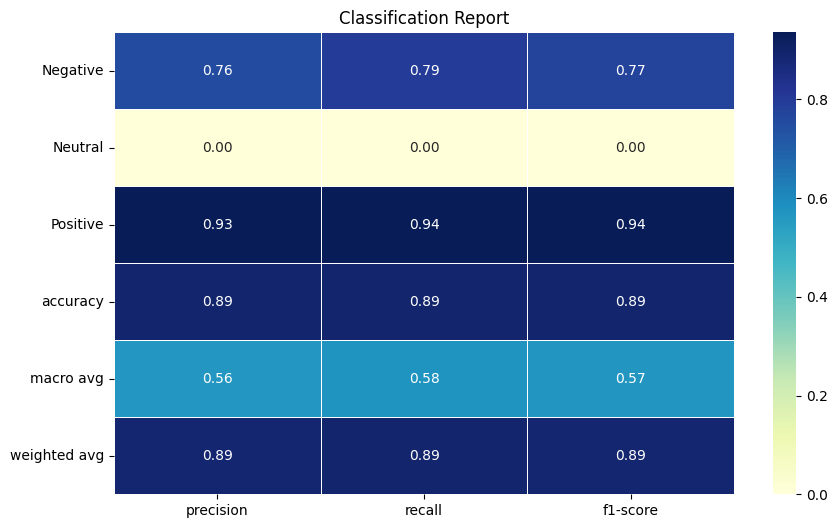

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the DataFrame using Seaborn's heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Classification Report')
plt.show()


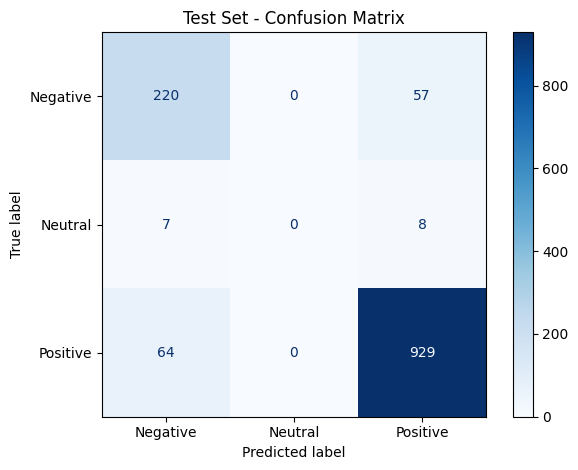

In [17]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

In [20]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AdamW
)
from sklearn.metrics import accuracy_score

# Define LLaMA Model with Classification Head
class LlamaForClassification(nn.Module):
    def __init__(self, model_name, num_labels=3):
        super(LlamaForClassification, self).__init__()
        self.model = AutoModelForCausalLM.from_pretrained(model_name)  # Load base LLaMA model
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)  # Classification head

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_state = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token representation
        logits = self.classifier(hidden_state)  # Apply classification layer
        return logits  # Return class scores

# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set EOS as padding token

# Load fine-tunable model
num_labels = 3  # Sentiment classes: Positive (2), Neutral (1), Negative (0)
model = LlamaForClassification(model_name, num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def preprocess_data(df):
    df["label"] = df["Sentiment"].map({"Positive": 2, "Negative": 0, "Neutral": 1})
    return df["News Content"].tolist(), df["label"].tolist()

train_texts, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Ensure text is a string
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Call tokenizer with 'text' argument
        encoding = self.tokenizer(
            text=text, # Pass text as a named argument
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets and data loaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)  # Get class logits
        loss = criterion(logits, labels)  # Compute loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "llama3_sentiment.pth")
print("Fine-tuned model saved successfully.")


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 40.12 MiB is free. Process 26257 has 14.70 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 338.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AdamW
)
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training
from torch.utils.checkpoint import checkpoint  # For gradient checkpointing

# Define LLaMA Model with Classification Head
class LlamaForClassification(nn.Module):
    def __init__(self, model_name, num_labels=3):
        super(LlamaForClassification, self).__init__()
        self.model = AutoModelForCausalLM.from_pretrained(model_name)  # Load base LLaMA model
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)  # Classification head

    def forward(self, input_ids, attention_mask):
        # Use gradient checkpointing to save memory
        outputs = checkpoint(self.model, input_ids, attention_mask, output_hidden_states=True)
        hidden_state = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token representation
        logits = self.classifier(hidden_state)  # Apply classification layer
        return logits  # Return class scores

# Load tokenizer
model_name = "meta-llama/Llama-3.2-700M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set EOS as padding token

# Load fine-tunable model
num_labels = 3  # Sentiment classes: Positive (2), Neutral (1), Negative (0)
model = LlamaForClassification(model_name, num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Preprocess data
def preprocess_data(df):
    df["label"] = df["Sentiment"].map({"Positive": 2, "Negative": 0, "Neutral": 1})
    return df["News Content"].tolist(), df["label"].tolist()

train_texts, train_labels = preprocess_data(train)  # Replace `train` with your training DataFrame
test_texts, test_labels = preprocess_data(validation)  # Replace `validation` with your validation DataFrame

# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text=text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create datasets and data loaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Reduced batch size
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Mixed precision training
scaler = GradScaler()

# Training loop
num_epochs = 3
accumulation_steps = 4  # Gradient accumulation steps

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast():  # Mixed precision
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / accumulation_steps  # Scale loss

        scaler.scale(loss).backward()  # Backpropagate with scaled loss

        if (i + 1) % accumulation_steps == 0:  # Perform optimizer step every `accumulation_steps` batches
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "llama3_sentiment.pth")
print("Fine-tuned model saved successfully.")

OSError: meta-llama/Llama-3.2-700M is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AdamW
)
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from peft import LoraConfig, get_peft_model

# Enable expandable segments to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Define LLaMA Model with Classification Head
class LlamaForClassification(nn.Module):
    def __init__(self, model_name, num_labels=3):
        super(LlamaForClassification, self).__init__()
        self.model = AutoModelForCausalLM.from_pretrained(model_name)  # Load base LLaMA model
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)  # Classification head

    def forward(self, input_ids, attention_mask):
        # Use gradient checkpointing
        outputs = checkpoint(self.model, input_ids, attention_mask, output_hidden_states=True)
        hidden_state = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token representation
        logits = self.classifier(hidden_state)  # Apply classification layer
        return logits  # Return class scores

# Load tokenizer
model_name = "meta-llama/Llama-3.2-3B"  # Use a smaller model
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set EOS as padding token

# Load fine-tunable model
num_labels = 3  # Sentiment classes: Positive (2), Neutral (1), Negative (0)
model = LlamaForClassification(model_name, num_labels)

# Apply LoRA
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank adaptation
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Target specific layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"  # Task type for classification
)
model = get_peft_model(model, lora_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Preprocess data
def preprocess_data(df):
    df["label"] = df["Sentiment"].map({"Positive": 2, "Negative": 0, "Neutral": 1})
    return df["News Content"].tolist(), df["label"].tolist()

train_texts, train_labels = preprocess_data(train)  # Replace `train` with your training DataFrame
test_texts, test_labels = preprocess_data(validation)  # Replace `validation` with your validation DataFrame

# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text=text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create datasets and data loaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Reduced batch size
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Mixed precision training
scaler = GradScaler()

# Training loop
num_epochs = 3
accumulation_steps = 4  # Gradient accumulation steps

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast():  # Mixed precision
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / accumulation_steps  # Scale loss

        scaler.scale(loss).backward()  # Backpropagate with scaled loss

        if (i + 1) % accumulation_steps == 0:  # Perform optimizer step every `accumulation_steps` batches
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")

# Save the fine-tuned model
model.save_pretrained("llama3_sentiment_lora")  # Save LoRA model
print("Fine-tuned model saved successfully.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
report = classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Classification Report')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
if not isinstance(test_true[0], str):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)
    labels = [0, 1, 2]
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive']

confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Load LLaMA model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

llama_model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llama_model.to(device)
llama_model.eval()  # Set to eval mode

def preprocess_data(df):
    df["label"] = df["Sentiment"].map({"Positive": 2, "Negative": 0, "Neutral": 1})
    return df["News Content"].tolist(), df["label"].tolist()

# Assume `train` and `validation` DataFrames exist
train_texts, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def extract_embeddings(dataloader):
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = llama_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Last layer hidden state
            sentence_embedding = hidden_states[:, 0, :].cpu().numpy()  # Extract [CLS] token embedding

            embeddings.extend(sentence_embedding)
            labels.extend(batch["labels"].cpu().numpy())

    return np.array(embeddings), np.array(labels)

# Extract embeddings
train_embeddings, train_labels = extract_embeddings(train_loader)
test_embeddings, test_labels = extract_embeddings(test_loader)

# Train Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_embeddings, train_labels)

# Predict on test set
test_preds = nb_classifier.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)

print(f"Naïve Bayes Test Accuracy: {accuracy:.4f}")


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load LLaMA model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

llama_model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llama_model.to(device)
llama_model.eval()  # Set to evaluation mode

# Function to preprocess data
def preprocess_data(df):
    df["label"] = df["Sentiment"].map({"Positive": 2, "Negative": 0, "Neutral": 1})
    return df["News Content"].tolist(), df["label"].tolist()

# Assume `train` and `validation` DataFrames exist
train_texts, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

# Custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets and dataloaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Function to extract embeddings from LLaMA
def extract_embeddings(dataloader):
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = llama_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Last layer hidden state
            sentence_embedding = hidden_states[:, 0, :].cpu().numpy()  # Extract [CLS] token embedding

            embeddings.extend(sentence_embedding)
            labels.extend(batch["labels"].cpu().numpy())

    return np.array(embeddings), np.array(labels)

# Extract embeddings
train_embeddings, train_labels = extract_embeddings(train_loader)
test_embeddings, test_labels = extract_embeddings(test_loader)

### OPTION 1: Use GaussianNB (Recommended)
nb_classifier = GaussianNB()
nb_classifier.fit(train_embeddings, train_labels)

# Predict on test set
test_preds = nb_classifier.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)

print(f"Naïve Bayes (GaussianNB) Test Accuracy: {accuracy:.4f}")

### OPTION 2: Use MultinomialNB (If Needed)
scaler = MinMaxScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

nb_classifier_mnb = MultinomialNB()
nb_classifier_mnb.fit(train_embeddings_scaled, train_labels)

test_preds_mnb = nb_classifier_mnb.predict(test_embeddings_scaled)
accuracy_mnb = accuracy_score(test_labels, test_preds_mnb)

print(f"Naïve Bayes (MultinomialNB) Test Accuracy: {accuracy_mnb:.4f}")
